# Documentation
## 1. Introduction

In this project, first we aim to analyze the variables that would contribute to high salary. 
In the second part, we want to study the relationship between working hours and other variables.
## 2. Dataset

The dataset contains 32k records and 15 variables in total. In the first part, the dependent variable will be the income which has two levels: high salary for more than 50k income and low salary for less or equal to 50k income. In addition, 24720 records are low salary and 7841 records are high salary, with the percentages being 76% versus 24% accordingly.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from patsy import dmatrices, dmatrix, demo_data
%matplotlib inline

# Reading the Data

In [2]:
income = pd.read_csv("income_data.csv", sep=r'\s*,\s*', engine='python')
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
income.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


# Basic EDA and Transformations

In [4]:
factors = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

In [5]:
# replace all the ? with NA
income[income == '?'] = np.nan

/Users/jiaxuewan/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [6]:
#Checking for nulls
income.isnull().values.any()

True

In [7]:
#impute Nulls with mode
for factor in factors:
    income[factor].fillna(value=income[factor].mode()[0], inplace=True)

## Data visualization
1. First draw correlation matrix 
2. Check relationship between independent variables against dependent variable
3. Then check the interrelationship among independent variables

In [8]:
#assigning levels to the values of categorical variables
income_fact = income.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [9]:
#correlation matrix visualization of the data
corr = income_fact.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
age,1,0.041,-0.077,-0.011,0.037,-0.27,0.0017,-0.26,0.029,0.089,0.078,0.058,0.069,-0.00027,0.23
workclass,0.041,1,-0.024,0.0049,0.0035,-0.02,0.0071,-0.058,0.048,0.072,0.032,0.0026,0.042,-0.0016,0.0027
fnlwgt,-0.077,-0.024,1,-0.028,-0.043,0.028,0.00019,0.0089,-0.021,0.027,0.00043,-0.01,-0.019,-0.063,-0.0095
education,-0.011,0.0049,-0.028,1,0.36,-0.038,-0.041,-0.011,0.014,-0.027,0.03,0.017,0.056,0.076,0.079
education-num,0.037,0.0035,-0.043,0.36,1,-0.069,0.071,-0.094,0.032,0.012,0.12,0.08,0.15,0.089,0.34
marital-status,-0.27,-0.02,0.028,-0.038,-0.069,1,0.035,0.19,-0.068,-0.13,-0.043,-0.034,-0.19,-0.021,-0.2
occupation,0.0017,0.0071,0.00019,-0.041,0.071,0.035,1,-0.037,-0.0048,0.047,0.018,0.0097,-0.013,-0.0022,0.035
relationship,-0.26,-0.058,0.0089,-0.011,-0.094,0.19,-0.037,1,-0.12,-0.58,-0.058,-0.061,-0.25,-0.011,-0.25
race,0.029,0.048,-0.021,0.014,0.032,-0.068,-0.0048,-0.12,1,0.087,0.011,0.019,0.042,0.12,0.072
sex,0.089,0.072,0.027,-0.027,0.012,-0.13,0.047,-0.58,0.087,1,0.048,0.046,0.23,0.0021,0.22


In [10]:
#checking for class imbalance
print(income['income'].value_counts())
print(str(round(income['income'].value_counts()[1]*100/income.shape[0],2)) + '%')

<=50K    24720
>50K      7841
Name: income, dtype: int64
24.08%


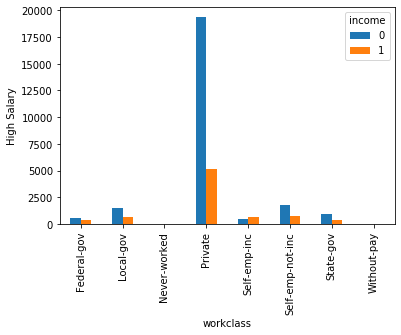

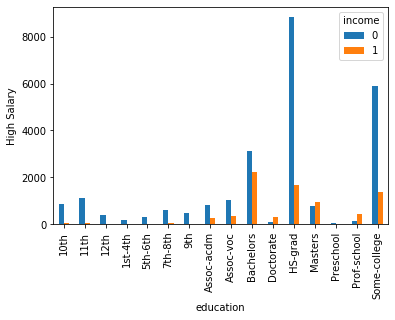

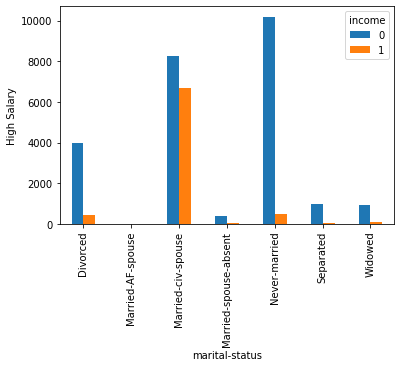

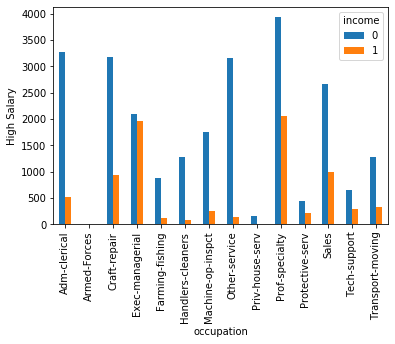

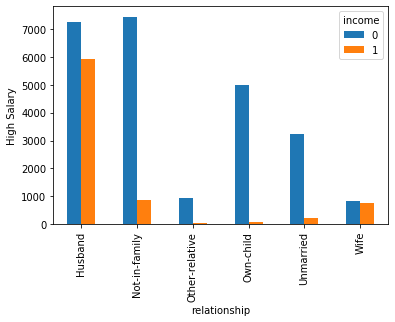

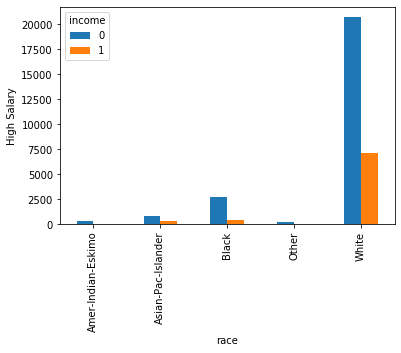

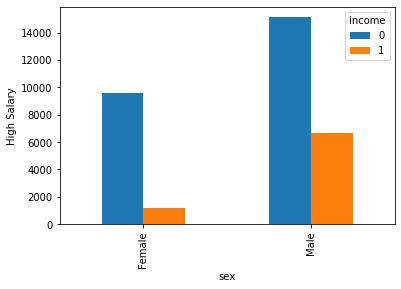

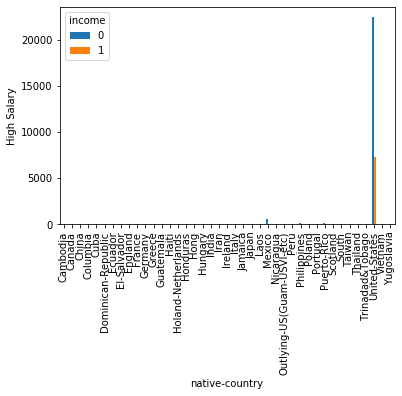

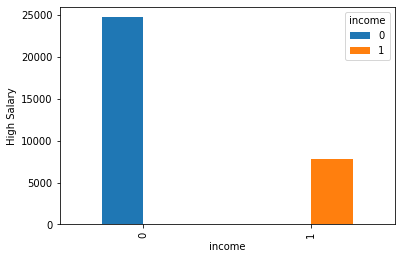

In [11]:
#determining if a variable is good predictor of income through plots (categorical variables)
for factor in factors:
    pd.crosstab(income[factor],income_fact['income']).plot(kind='bar')
    plt.xlabel(factor)
    plt.ylabel('High Salary')

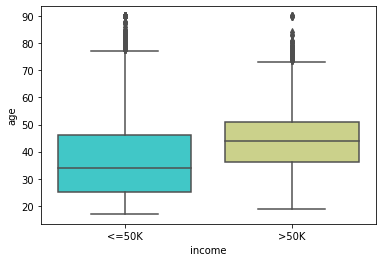

In [12]:
#determining if a variable is good predictor of income through plots (numeric variables)
sns.boxplot(x='income',y='age',data=income,palette='rainbow')

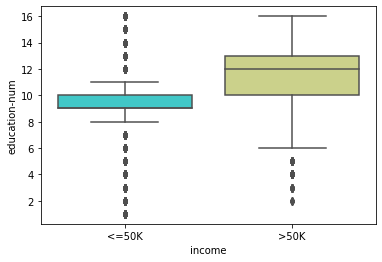

In [13]:
ax = sns.boxplot(x='income',y='education-num',data=income,palette='rainbow')

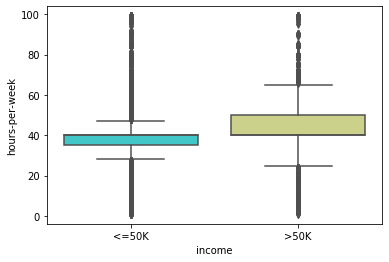

In [14]:
ax = sns.boxplot(x='income',y='hours-per-week',data=income,palette='rainbow')

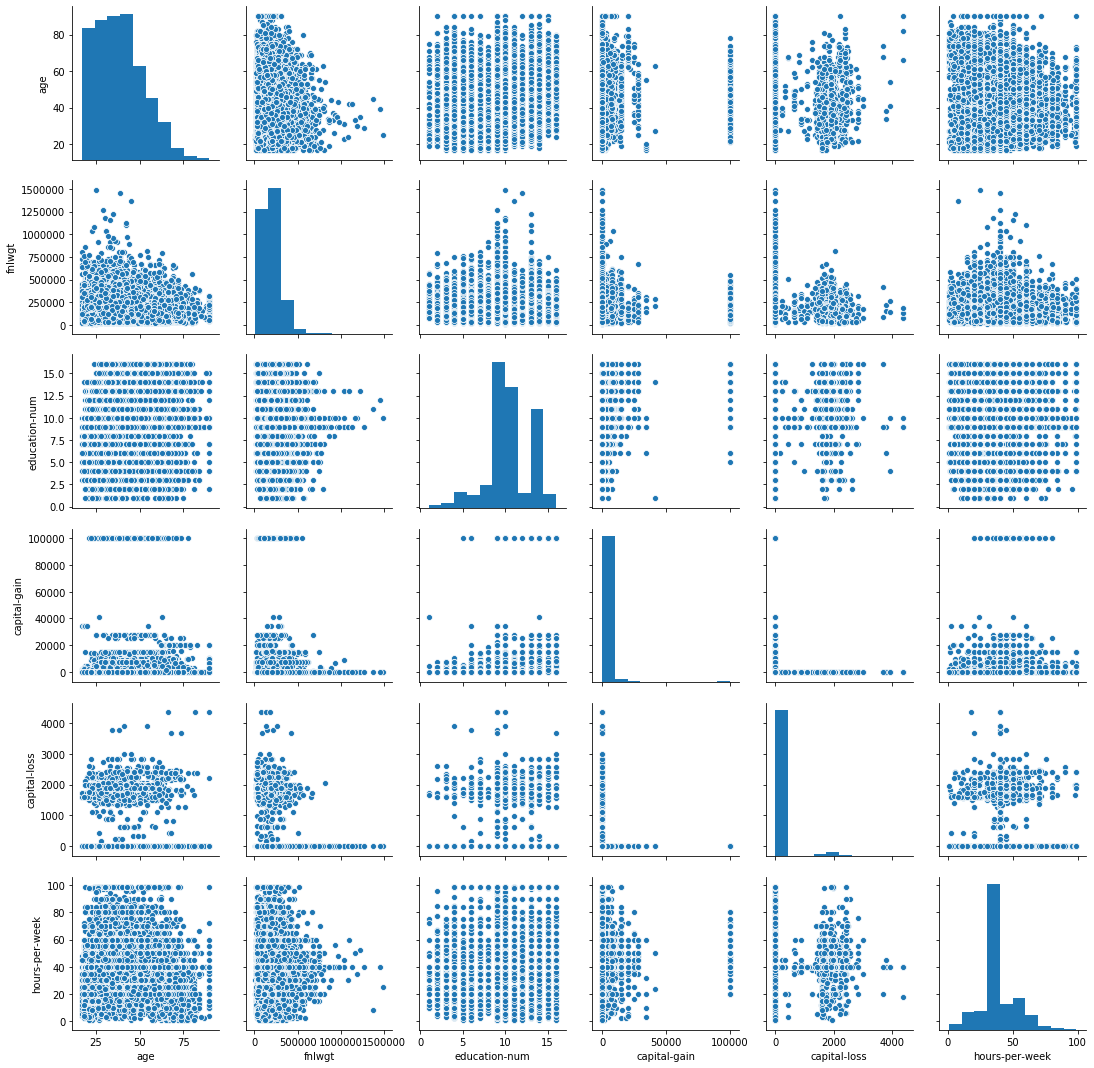

In [15]:
# Interrelationships of the variables
sns.pairplot(income, kind="scatter")
plt.show()

[Text(0, 0, 'Never-married'),
 Text(0, 0, 'Married-civ-spouse'),
 Text(0, 0, 'Divorced'),
 Text(0, 0, 'Married-spouse-absent'),
 Text(0, 0, 'Separated'),
 Text(0, 0, 'Married-AF-spouse'),
 Text(0, 0, 'Widowed')]

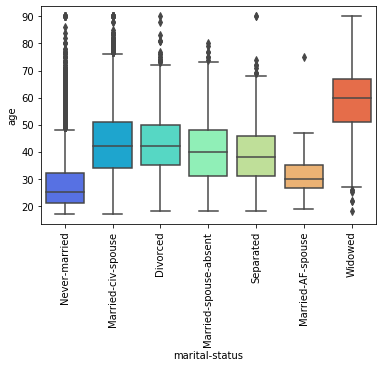

In [16]:
# Check the relationship between age and marital status
ax = sns.boxplot(x='marital-status',y='age',data=income,palette='rainbow')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

[Text(0, 0, 'Male'), Text(0, 0, 'Female')]

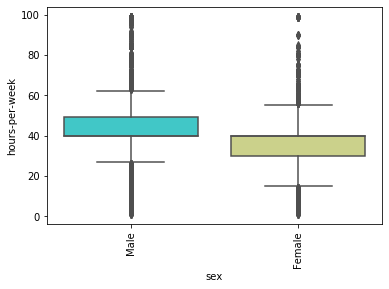

In [17]:
# Check the relationship between age and marital status
ax = sns.boxplot(x='sex',y='hours-per-week',data=income,palette='rainbow')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## EDA summary
1. All the categorical variables have significant variation in different levels which means they all help when deciding whether a person has a high salary or not. For example, as educational level increases, people earn more money. In Fig. 1, after people reach Master or beyond, more than 50% of them are likely to earn a high salary. Similarly, after assigning numeric values to each education level, people with high salary apparently have a higher education level than others.

2. Another interesting finding is that, people who have a complete family tend to have a higher salary than people who are single.

3. In terms of sex, male normally earns more than female. However, it also turns out that male works longer hours per week. Thus, a tradeoff between working hours and salary exists.


## Merge some levels of categorical variables

In [18]:
print(income['education'].unique())
print(income['workclass'].unique())
print(income['marital-status'].unique())
print(income['occupation'].unique())
print(income['race'].unique())
print(income['native-country'].unique())

['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' 'Protective-serv'
 'Armed-Forces' 'Priv-house-serv']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['United-States' 'Cuba' 'Jamaica' 'India' 'Mexico' 'South' 'Puerto-Rico'
 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines' 'Italy'
 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos' 'Taiwan'
 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador' 'France'
 'Guatemala' 'Chi

In [19]:
#merging levels based on common sense, similar categories or few data points (check following visualiztaions as well)
income['education'] = income['education'].replace(['11th','9th','7th-8th','5th-6th', '10th', '1st-4th','12th','Preschool'], 'Not-HS-Grad')
income['workclass'] = income['workclass'].replace(['State-gov', 'Federal-gov', 'Local-gov'], 'Gov')
income['workclass'] = income['workclass'].replace(['Self-emp-inc', 'Never-worked', 'Without-pay'], 'Other')
income['marital-status'] = income['marital-status'].replace(['Married-spouse-absent', 'Married-civ-spouse', 'Married-AF-spouse'], 'Married')
income['marital-status'] = income['marital-status'].replace(['Widowed', 'Divorced', 'Separated'], 'Separated')
income['occupation'] = income['occupation'].replace(['Armed-Forces','Priv-house-serv','Other-service'], 'Other')
income['race']=np.where(income['race'] =='Amer-Indian-Eskimo', 'Other', income['race'])
income['native-country']=np.where(income['native-country'] !='United-States', 'Other', income['native-country'])


In [20]:
# check all the levels after merging
print(income['education'].unique())
print(income['workclass'].unique())
print(income['marital-status'].unique())
print(income['occupation'].unique())
print(income['race'].unique())
print(income['native-country'].unique())

['Bachelors' 'HS-grad' 'Not-HS-Grad' 'Masters' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' 'Doctorate' 'Prof-school']
['Gov' 'Self-emp-not-inc' 'Private' 'Other']
['Never-married' 'Married' 'Separated']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other' 'Sales' 'Craft-repair' 'Transport-moving' 'Farming-fishing'
 'Machine-op-inspct' 'Tech-support' 'Protective-serv']
['White' 'Black' 'Asian-Pac-Islander' 'Other']
['United-States' 'Other']


In [21]:
# serve for the later interaction part because '-' can not be written in the formula
income = income.replace(to_replace = '-', value = '_', regex=True)
income.rename(columns={'education-num':'education_num',
                          'marital-status':'marital_status',
                          'capital-gain':'capital_gain','capital-loss':'capital_loss'
                          ,'hours-per-week':'hours_per_week',
                          'native-country':'native_country'}, 
                 inplace=True)

In [22]:
# After data wrangling and before visualization, we copy the data to prepare for several models afterwards
income2 = income.copy()
income3 = income.copy()

In [23]:
# Since the column names changed, we list them again.
factors = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']

## Feature elimination 
1. numeric vairables: using RFE
2. Categorical variables: EDA

Since we cannot remove single level of one categorical variable, it will be difficult to use techniques like RFE to eliminate categorical variables.

In [24]:
# All the numeric variables
X = income[['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']]

In [25]:
income['income'] = income['income'].factorize()[0]
Y = income['income']

In [26]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=None, step=10, verbose=5)
rfe_selector.fit(X, Y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 6 features.
3 selected features


In [27]:
# These are features considered to be important
rfe_feature

['age', 'education_num', 'hours_per_week']

In [28]:
# So we drop other features
income = income.drop('fnlwgt', 1)
income = income.drop('capital_gain', 1)
income = income.drop('capital_loss', 1)

## Creating Dummy Variables

In [29]:
income.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,Gov,Bachelors,13,Never_married,Adm_clerical,Not_in_family,White,Male,40,United_States,0
1,50,Self_emp_not_inc,Bachelors,13,Married,Exec_managerial,Husband,White,Male,13,United_States,0
2,38,Private,HS_grad,9,Separated,Handlers_cleaners,Not_in_family,White,Male,40,United_States,0
3,53,Private,Not_HS_Grad,7,Married,Handlers_cleaners,Husband,Black,Male,40,United_States,0
4,28,Private,Bachelors,13,Married,Prof_specialty,Wife,Black,Female,40,Other,0


In [30]:
income_dummy = income.copy()
for var in factors:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_dummy[var], prefix=var,drop_first=True)
        income_dummy = pd.concat([income_dummy,cat_list], axis = 1)
        income_dummy = income_dummy.drop(var, 1)
income_dummy.head()

,age,education_num,hours_per_week,income,workclass_Other,workclass_Private,workclass_Self_emp_not_inc,education_Assoc_voc,education_Bachelors,education_Doctorate,...,relationship_Not_in_family,relationship_Other_relative,relationship_Own_child,relationship_Unmarried,relationship_Wife,race_Black,race_Other,race_White,sex_Male,native_country_United_States
0,39,13,40,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,1
1,50,13,13,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,38,9,40,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1
3,53,7,40,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,28,13,40,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0


# Test-Training Set Split and Fitting

In [31]:
#70% records being sent into training set 
income_dummy['income'] = income_dummy['income'].factorize()[0]
pts = np.random.rand(len(income_dummy)) < 0.7

income_train = income_dummy[pts]
income_test = income_dummy[~pts]

X_train = income_train.copy()
X_train = X_train.drop('income', 1)
Y_train = income_train['income']

#fitting the model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
#generating confusion matrix
X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']
Y_pred = logreg.predict(X_test)
cm_income = confusion_matrix(Y_test, Y_pred)
print(cm_income)

[[6921  572]
 [1055 1307]]


In [33]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))

Accuracy: 0.8349061390157281
Precision: 0.6955827567855242
Recall: 0.5533446232006773


## Model improvement: deal with data imbalance
not sure if to include this part because the results has no improvement

In [34]:
income_dummy.head()

,age,education_num,hours_per_week,income,workclass_Other,workclass_Private,workclass_Self_emp_not_inc,education_Assoc_voc,education_Bachelors,education_Doctorate,...,relationship_Not_in_family,relationship_Other_relative,relationship_Own_child,relationship_Unmarried,relationship_Wife,race_Black,race_Other,race_White,sex_Male,native_country_United_States
0,39,13,40,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,1
1,50,13,13,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,38,9,40,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1
3,53,7,40,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,28,13,40,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0


In [35]:
# oversampling
income_minority = income_dummy[income_dummy['income'] == 1]
income_majority = income_dummy[income_dummy['income'] == 0]
income_minority_unsampled = resample(income_minority, replace = True, n_samples = len(income_minority) * 2, random_state = 123)
income_resampled = pd.concat([income_majority, income_minority_unsampled])

In [36]:
print(income_resampled['income'].value_counts())
print(str(round(income_resampled['income'].value_counts()[1]*100/income_resampled.shape[0],2)) + '%')

0    24720
1    15682
Name: income, dtype: int64
38.81%


In [37]:
income_resampled.head()

,age,education_num,hours_per_week,income,workclass_Other,workclass_Private,workclass_Self_emp_not_inc,education_Assoc_voc,education_Bachelors,education_Doctorate,...,relationship_Not_in_family,relationship_Other_relative,relationship_Own_child,relationship_Unmarried,relationship_Wife,race_Black,race_Other,race_White,sex_Male,native_country_United_States
0,39,13,40,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,1
1,50,13,13,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,38,9,40,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1
3,53,7,40,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,28,13,40,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0


In [38]:
pts2 = np.random.rand(len(income_resampled)) < 0.7

income_train2 = income_resampled[pts2]
income_test2 = income_resampled[~pts2]

X_train2 = income_train2.copy()
X_train2 = X_train2.drop('income', 1)
Y_train2 = income_train2['income']

#fitting the model
logreg2 = LogisticRegression()
logreg2.fit(X_train2, Y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
#generating confusion matrix
X_test2 = income_test2.copy()
X_test2 = X_test2.drop('income', 1)
Y_test2 = income_test2['income']
Y_pred2 = logreg2.predict(X_test2)
cm2= confusion_matrix(Y_test2, Y_pred2)
print(cm2)

[[6364 1240]
 [1216 3454]]


In [41]:
print("Accuracy:",metrics.accuracy_score(Y_test2, Y_pred2))
print("Precision:",metrics.precision_score(Y_test2, Y_pred2))
print("Recall:",metrics.recall_score(Y_test2, Y_pred2))

Accuracy: 0.7999022323610885
Precision: 0.735832978270132
Recall: 0.7396145610278373


Accuracy decreased but recall rate increased a lot. Model is improved by oversampling.

# regress work hours on the rest of the data

In [42]:
income2.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,Gov,77516,Bachelors,13,Never_married,Adm_clerical,Not_in_family,White,Male,2174,0,40,United_States,<=50K
1,50,Self_emp_not_inc,83311,Bachelors,13,Married,Exec_managerial,Husband,White,Male,0,0,13,United_States,<=50K
2,38,Private,215646,HS_grad,9,Separated,Handlers_cleaners,Not_in_family,White,Male,0,0,40,United_States,<=50K
3,53,Private,234721,Not_HS_Grad,7,Married,Handlers_cleaners,Husband,Black,Male,0,0,40,United_States,<=50K
4,28,Private,338409,Bachelors,13,Married,Prof_specialty,Wife,Black,Female,0,0,40,Other,<=50K


In [43]:
income2_dummy = income2
for var in factors:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(income2_dummy[var], prefix=var,drop_first=True)
    income2_dummy = pd.concat([income2_dummy,cat_list], axis = 1)
    income2_dummy = income2_dummy.drop(var, 1)
income2_dummy.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Other,workclass_Private,workclass_Self_emp_not_inc,education_Assoc_voc,...,relationship_Other_relative,relationship_Own_child,relationship_Unmarried,relationship_Wife,race_Black,race_Other,race_White,sex_Male,native_country_United_States,income_>50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
1,50,83311,13,0,0,13,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
2,38,215646,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0
3,53,234721,7,0,0,40,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0
4,28,338409,13,0,0,40,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0


In [68]:
X_workhour = income2_dummy.copy()
X_workhour = X_workhour.drop('hours_per_week', 1)
Y_workhour = income2_dummy['hours_per_week']

X_workhour = sm.add_constant(X_workhour)
reg_workhour = sm.OLS(Y_workhour, X_workhour)
results_workhour = reg_workhour.fit()
print(results_workhour.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     189.3
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:32:12   Log-Likelihood:            -1.2463e+05
No. Observations:               32561   AIC:                         2.494e+05
Df Residuals:                   32520   BIC:                         2.497e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Club insignificant levels together logically

In [45]:
# Since all the race related levels are insignificant, we remove race.
income2 = income2.drop(['race','native_country','workclass'], axis = 1)

In [46]:
print('Handlers_cleaners: ',len(income2[income2['occupation'] == 'Handlers_cleaners'])/len(income2))
print('Tech-support: ',len(income2[income2['occupation'] == 'Tech-support'])/len(income2))
print('Assoc_voc: ',len(income2[income2['education'] == 'Assoc_voc'])/len(income2))
print('Unmarried: ',len(income2[income2['relationship'] == 'Unmarried'])/len(income2))
print('Not_in_family: ',len(income2[income2['relationship'] == 'Not_in_family'])/len(income2))
print('Separated: ',len(income2[income2['marital_status'] == 'Separated'])/len(income2))

Handlers_cleaners:  0.04207487485028101
Tech-support:  0.0
Assoc_voc:  0.042443413900064494
Unmarried:  0.10583213046282362
Not_in_family:  0.2550597340376524
Separated:  0.1984275667209238


### Since the data points of some of these levels are too few (smaller than 5%), we merge them together with other categories. For the others, we continue to merge them based on the basis of logic.


In [47]:
income2['occupation'].unique()

array(['Adm_clerical', 'Exec_managerial', 'Handlers_cleaners',
       'Prof_specialty', 'Other', 'Sales', 'Craft_repair',
       'Transport_moving', 'Farming_fishing', 'Machine_op_inspct',
       'Tech_support', 'Protective_serv'], dtype=object)

In [48]:
income2['occupation'] = income2['occupation'].replace(['Tech_support','Handlers_cleaners'], 'Other')
income2['education'] = income2['education'].replace(['Assoc_acdm'], 'Assoc')
income2['education'] = income2['education'].replace(['Assoc_voc'], 'Assoc')
income2['relationship'] = income2['relationship'].replace(['Unmarried'], 'Not_in_family')
income2['marital_status'] = income2['marital_status'].replace(['Separated'], 'Never_married')

In [49]:
income2['occupation'].unique()

array(['Adm_clerical', 'Exec_managerial', 'Other', 'Prof_specialty',
       'Sales', 'Craft_repair', 'Transport_moving', 'Farming_fishing',
       'Machine_op_inspct', 'Protective_serv'], dtype=object)

In [50]:
factors = ['education', 'marital_status', 'occupation', 'relationship', 'sex', 'income']

In [51]:
income3_dummy = income2.copy()
for var in factors:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(income3_dummy[var], prefix=var,drop_first=True)
    income3_dummy = pd.concat([income3_dummy,cat_list], axis = 1)
    income3_dummy = income3_dummy.drop(var, 1)
income3_dummy.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,education_Bachelors,education_Doctorate,education_HS_grad,education_Masters,...,occupation_Prof_specialty,occupation_Protective_serv,occupation_Sales,occupation_Transport_moving,relationship_Not_in_family,relationship_Other_relative,relationship_Own_child,relationship_Wife,sex_Male,income_>50K
0,39,77516,13,2174,0,40,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,50,83311,13,0,0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,338409,13,0,0,40,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [52]:
X_workhour2 = income3_dummy.copy()
X_workhour2 = X_workhour2.drop('hours_per_week', 1)
Y_workhour2 = income3_dummy['hours_per_week']

X_workhour2 = sm.add_constant(X_workhour2)
reg_workhour2 = sm.OLS(Y_workhour2, X_workhour2)
results_workhour2 = reg_workhour2.fit()
results_workhour2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     251.7
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:29:28   Log-Likelihood:            -1.2485e+05
No. Observations:               32561   AIC:                         2.498e+05
Df Residuals:                   32532   BIC:                         2.500e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           49.6274      1.250     39.704      0.000      47.177      52.077
age                             -0.0979      0.005    -18.431      0.000      -0.108      -0.087
fnlwgt                       -2.102e-06   5.92e-07     -3.550      0.000   -3.26e-06   -9.41e-07
education_num                   -0.5729      0.101     -5.699      0.000      -0.770      -0.376
capital_gain                  3.838e-05   8.75e-06      4.388      0.000    2.12e-05    5.55e-05
capital_loss                     0.0004      0.000      2.332      0.020    5.82e-05       0.001
education_Bachelors              1.5078      0.319      4.726      0.000       0.882       2.133
education_Doctorate              7.6994      0.768     10.023      0.000       6.194       9.205
education_HS_grad               -1.8801      0.351     -5.353      0.000      -2.569      -1.192
education_Masters                3.1980      0.447      7.156      0.000       2.322       4.074
education_Not_HS_Grad           -6.4838      0.651     -9.961      0.000      -7.760      -5.208
education_Prof_school            7.0945      0.651     10.893      0.000       5.818       8.371
education_Some_college          -2.2401      0.301     -7.436      0.000      -2.831      -1.650
marital_status_Never_married    -1.4086      0.453     -3.112      0.002      -2.296      -0.521
occupation_Craft_repair          1.8002      0.272      6.630      0.000       1.268       2.332
occupation_Exec_managerial       3.3642      0.267     12.616      0.000       2.842       3.887
occupation_Farming_fishing       7.5839      0.413     18.341      0.000       6.773       8.394
occupation_Machine_op_inspct     1.7965      0.321      5.605      0.000       1.168       2.425
occupation_Other                -1.4430      0.241     -5.985      0.000      -1.916      -0.970
occupation_Prof_specialty       -1.5543      0.249     -6.247      0.000      -2.042      -1.067
occupation_Protective_serv       2.1171      0.483      4.382      0.000       1.170       3.064
occupation_Sales                 1.3794      0.265      5.198      0.000       0.859       1.900
occupation_Transport_moving      4.6108      0.350     13.166      0.000       3.924       5.297
relationship_Not_in_family       0.9817      0.472      2.082      0.037       0.057       1.906
relationship_Other_relative     -2.2612      0.542     -4.174      0.000      -3.323      -1.199
relationship_Own_child          -6.3742      0.493    -12.928      0.000      -7.341      -5.408
relationship_Wife               -3.5298      0.346    -10.198      0.000      -4.208      -2.851
sex_Male                         2.9014      0.177     16.352      0.000       2.554       3.249
income_>50K                      3.3538      0.180     18.593      0.000    

After fitting the model with only the significant variables, R^2 decreased.

### Explore interaction terms
Below I explore interaction terms among numeric variables and I found age:education_num is both significant and it contributes to adj.R^2

In [53]:
income2.head()

,age,fnlwgt,education,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,hours_per_week,income
0,39,77516,Bachelors,13,Never_married,Adm_clerical,Not_in_family,Male,2174,0,40,<=50K
1,50,83311,Bachelors,13,Married,Exec_managerial,Husband,Male,0,0,13,<=50K
2,38,215646,HS_grad,9,Never_married,Other,Not_in_family,Male,0,0,40,<=50K
3,53,234721,Not_HS_Grad,7,Married,Other,Husband,Male,0,0,40,<=50K
4,28,338409,Bachelors,13,Married,Prof_specialty,Wife,Female,0,0,40,<=50K


In [54]:
Y_interaction,X_interaction = dmatrices('hours_per_week ~ age:education_num+age:sex+age+education+education_num+marital_status+occupation+relationship+sex+income',data = income2,return_type = 'dataframe')


In [55]:
model_interaction = sm.OLS(Y_interaction,X_interaction)
reg_interaction = model_interaction.fit()
print(reg_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     263.8
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:29:49   Log-Likelihood:            -1.2482e+05
No. Observations:               32561   AIC:                         2.497e+05
Df Residuals:                   32533   BIC:                         2.499e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### After adding interaction terms, R^2 increased. Age:education_num and age:sex are both statistically significant, indicating education level and sex have important impact on the relationship between age and working hour.

# Regress work hours of only people who are working in Sales

In [56]:
income3.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,Gov,77516,Bachelors,13,Never_married,Adm_clerical,Not_in_family,White,Male,2174,0,40,United_States,<=50K
1,50,Self_emp_not_inc,83311,Bachelors,13,Married,Exec_managerial,Husband,White,Male,0,0,13,United_States,<=50K
2,38,Private,215646,HS_grad,9,Separated,Handlers_cleaners,Not_in_family,White,Male,0,0,40,United_States,<=50K
3,53,Private,234721,Not_HS_Grad,7,Married,Handlers_cleaners,Husband,Black,Male,0,0,40,United_States,<=50K
4,28,Private,338409,Bachelors,13,Married,Prof_specialty,Wife,Black,Female,0,0,40,Other,<=50K


In [57]:
income3 = income3[income3['occupation'] == 'Sales']

In [58]:
factors = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']

In [59]:
income4_dummy = income3.copy()
for var in factors:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(income4_dummy[var], prefix=var,drop_first=True)
    income4_dummy = pd.concat([income4_dummy,cat_list], axis = 1)
    income4_dummy = income4_dummy.drop(var, 1)
income4_dummy.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Other,workclass_Private,workclass_Self_emp_not_inc,education_Assoc_voc,...,relationship_Other_relative,relationship_Own_child,relationship_Unmarried,relationship_Wife,race_Black,race_Other,race_White,sex_Male,native_country_United_States,income_>50K
13,32,205019,12,0,0,50,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0
18,38,28887,7,0,0,50,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0
31,20,266015,10,0,0,44,0,1,0,0,...,0,1,0,0,1,0,0,1,1,0
38,31,84154,10,0,0,38,0,1,0,0,...,0,0,0,0,0,0,1,1,1,1
60,30,59496,13,2407,0,40,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0


In [60]:
X_workhour3 = income4_dummy.copy()
X_workhour3 = X_workhour3.drop('hours_per_week', 1)
Y_workhour3 = income4_dummy['hours_per_week']

X_workhour3 = sm.add_constant(X_workhour3)
reg_workhour3 = sm.OLS(Y_workhour3, X_workhour3)
results_workhour3 = reg_workhour3.fit()
results_workhour3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     51.79
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          4.27e-247
Time:                        18:31:35   Log-Likelihood:                -13973.
No. Observations:                3650   AIC:                         2.801e+04
Df Residuals:                    3620   BIC:                         2.819e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           53.1384      5.927      8.965      0.000      41.518      64.759
age                             -0.1331      0.018     -7.417      0.000      -0.168      -0.098
fnlwgt                       -1.277e-06   1.82e-06     -0.702      0.483   -4.85e-06    2.29e-06
education_num                   -0.6695      0.436     -1.535      0.125      -1.525       0.186
capital_gain                  5.195e-05   2.23e-05      2.332      0.020    8.27e-06    9.56e-05
capital_loss                     0.0004      0.000      0.867      0.386      -0.000       0.001
workclass_Other                  6.7201      2.090      3.216      0.001       2.623      10.817
workclass_Private                1.5558      1.994      0.780      0.435      -2.354       5.465
workclass_Self_emp_not_inc       4.6532      2.066      2.253      0.024       0.603       8.703
education_Assoc_voc             -1.6765      1.498     -1.119      0.263      -4.614       1.261
education_Bachelors              0.8773      1.108      0.792      0.429      -1.295       3.050
education_Doctorate              2.9257      4.457      0.656      0.512      -5.812      11.663
education_HS_grad               -2.6312      1.642     -1.602      0.109      -5.851       0.589
education_Masters                1.1238      1.623      0.692      0.489      -2.058       4.306
education_Not_HS_Grad          -10.5383      2.767     -3.809      0.000     -15.963      -5.114
education_Prof_school            0.4274      3.100      0.138      0.890      -5.651       6.506
education_Some_college          -2.9429      1.332     -2.209      0.027      -5.554      -0.331
marital_status_Never_married    -2.4619      1.472     -1.673      0.094      -5.347       0.423
marital_status_Separated         1.4435      1.534      0.941      0.347      -1.564       4.451
relationship_Not_in_family       0.1908      1.535      0.124      0.901      -2.819       3.201
relationship_Other_relative     -3.9148      1.746     -2.242      0.025      -7.339      -0.491
relationship_Own_child          -9.1817      1.562     -5.877      0.000     -12.245      -6.119
relationship_Unmarried          -1.0413      1.655     -0.629      0.529      -4.286       2.204
relationship_Wife               -2.2499      1.149     -1.957      0.050      -4.504       0.004
race_Black                      -2.3184      1.407     -1.648      0.099      -5.076       0.440
race_Other                       0.8746      1.939      0.451      0.652      -2.927       4.677
race_White                      -1.6209      1.218     -1.330      0.183      -4.010       0.768
sex_Male                         5.5376      0.525     10.548      0.000       4.508       6.567
native_country_United_States    -0.5197      0.879     -0.591      0.554    

### First drop insignificant numerical variables and categorical variables of which most levels are insignificant

In [61]:
income4 = income3.drop('fnlwgt',axis = 1)
income4 = income4.drop('education_num',axis = 1)
income4 = income4.drop('capital_loss',axis = 1)
income4 = income4.drop('race',axis = 1)
income4 = income4.drop('native_country',axis = 1)
income4 = income4.drop('marital_status',axis = 1)
income4 = income4.drop('education',axis = 1)
income4 = income4.drop('workclass',axis = 1)
income4.head()

,age,occupation,relationship,sex,capital_gain,hours_per_week,income
13,32,Sales,Not_in_family,Male,0,50,<=50K
18,38,Sales,Husband,Male,0,50,<=50K
31,20,Sales,Own_child,Male,0,44,<=50K
38,31,Sales,Husband,Male,0,38,>50K
60,30,Sales,Husband,Male,2407,40,<=50K


### Then we merge insignificant levels

In [62]:
income4['relationship'].value_counts()

Husband           1506
Not_in_family      881
Own_child          710
Unmarried          319
Wife               130
Other_relative     104
Name: relationship, dtype: int64

In [63]:
# We merge insignificant levels
# relationship
income4['relationship'] = income4['relationship'].replace(['Not_in_family','Unmarried'], 'Other_relative')
income4['relationship'] = income4['relationship'].replace(['Own_child','Husband','Wife'], 'family')

In [64]:
factors = ['occupation','relationship','income','sex']

In [65]:
income4.head()

,age,occupation,relationship,sex,capital_gain,hours_per_week,income
13,32,Sales,Other_relative,Male,0,50,<=50K
18,38,Sales,family,Male,0,50,<=50K
31,20,Sales,family,Male,0,44,<=50K
38,31,Sales,family,Male,0,38,>50K
60,30,Sales,family,Male,2407,40,<=50K


In [66]:
income5_dummy = income4.copy()
for var in factors:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(income5_dummy[var], prefix=var,drop_first=True)
    income5_dummy = pd.concat([income5_dummy,cat_list], axis = 1)
    income5_dummy = income5_dummy.drop(var, 1)
income5_dummy.head()

,age,capital_gain,hours_per_week,relationship_family,income_>50K,sex_Male
13,32,0,50,0,0,1
18,38,0,50,1,0,1
31,20,0,44,1,0,1
38,31,0,38,1,1,1
60,30,2407,40,1,0,1


In [67]:
X_workhour4 = income5_dummy.copy()
X_workhour4 = X_workhour4.drop('hours_per_week', 1)
Y_workhour4 = income5_dummy['hours_per_week']

X_workhour4 = sm.add_constant(X_workhour4)
reg_workhour4 = sm.OLS(Y_workhour4, X_workhour4)
results_workhour4 = reg_workhour4.fit()
print(results_workhour4.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     176.1
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          2.98e-168
Time:                        18:31:54   Log-Likelihood:                -14212.
No. Observations:                3650   AIC:                         2.844e+04
Df Residuals:                    3644   BIC:                         2.847e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  33.5766    

## Summary

In this part, we fit the same model but only for a specific proportion of people whose occupation is Sales. Similarly, we decided to drop the insignificant numerical variables and merge the insignificant levels of the categorical variables and run the regression. Here we find that the R squared value of the reduced model is smaller than that of the full model. Hence, we conclude that the full model is a more reasonable fit as the goal is to get better predictions.
The final model that we chose here has an adjusted R squared value of 0.288 which is higher than what we see for the previous question (0.177). This shows that predicting the work hours for a single occupation (Sales in this case) is easier than predicting the work hours for all occupations together.